# Competition where metric is rmse of log of prices
[Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=train.csv)

In [70]:
# Set up code checking
# Set up filepaths
import os
os.chdir(os.path.join(os.path.expanduser('~'), 'kaggle'))

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


## Load data into dataframes

In [72]:
train_path = os.path.join('data', 'house-prices-advanced-regression', 'train.csv')
train_data = pd.read_csv(train_path)

test_path = os.path.join('data', 'house-prices-advanced-regression', 'test.csv')
test_data = pd.read_csv(test_path)

## Select numerical and categorical variables, and separate target from features

In [73]:
y = np.log(train_data['SalePrice'])
train_data.drop(columns=['SalePrice', 'Id'], inplace=True)
test_data.drop(columns=['Id'], inplace=True)

numerical_columns = train_data.select_dtypes(include=np.number).columns.tolist()

numerical_columns.remove('MSSubClass')

categorical_columns = [c for c in train_data.columns if c not in numerical_columns]

print(numerical_columns)
print(categorical_columns)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCon

## Some EDA and feature removal

count    1460.000000
mean        5.844521
std        48.623081
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       572.000000
Name: LowQualFinSF, dtype: float64
26


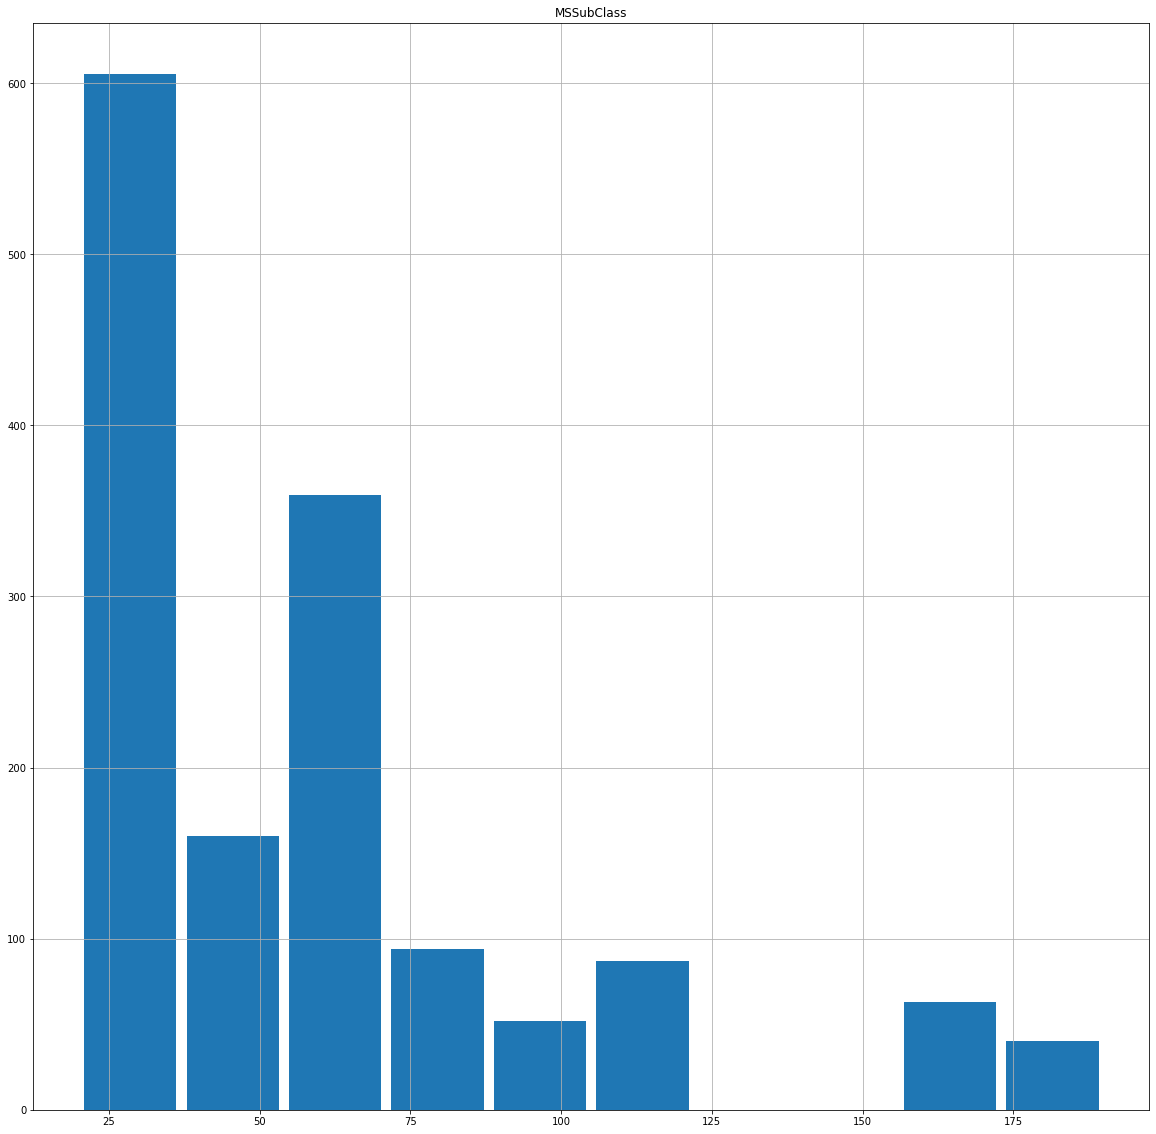

In [74]:
fig = train_data.hist(column=numerical_columns, figsize=(20, 20), rwidth=0.9)

# remove stupid columns
print(train_data['LowQualFinSF'].describe())
print(train_data[train_data['LowQualFinSF'] > 0]['LowQualFinSF'].count())

## Add missing data col for every column with missing data

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

# adds additional column which indicates whether data was missing for given feature
class AddMissingIndicator(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_columns):
        self.numeric_columns = numeric_columns
        self.num_cols_with_na = [] 

    def fit(self, X, y=None):
        self.num_cols_with_na = [c for c in self.numeric_columns if X[c].isna().any()]
        return self
    
    def transform(self, X, y=None):
        for c in self.num_cols_with_na:
            missing_col_name = f"{c}_is_missing"
            X[missing_col_name] = np.where(X[c].isna(), 1, 0)
        
        return X 


cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')), 
    ('OHE', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

num_pipeline = Pipeline(steps=[
    ('missing_indicator', AddMissingIndicator(numerical_columns)),
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])


preprocessing = ColumnTransformer(transformers=[
    ('numerical', num_pipeline, numerical_columns),
    ('categorical', cat_pipeline, categorical_columns)
])



In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error 

X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.2)

## Test different regression models

In [8]:
from sklearn.linear_model import Lasso, Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

models = {
    'ridge': Ridge(),
    'lasso': Lasso(random_state=1),
    'xgboost': XGBRegressor(random_state=1, eval_metric='rmse'),
    'GBR': GradientBoostingRegressor(loss='squared_error', random_state=1),
}

pipelines = {key: Pipeline(steps=[
    ('preprocessing', preprocessing),
    (f'{key}', models[key])
]) for key in models}

def get_rmse(predictor, X_train, y_train, X_test, y_test):
    predictor.fit(X_train, y_train)
    predictions = predictor.predict(X_test)
    return mean_squared_error(predictions, y_test, squared=False) # to return rmse and not mse


for p in pipelines:
    predictor = pipelines[p]
    mae = get_rmse(predictor, X_train, y_train, X_test, y_test)
    print(f"Model: {p}")
    print(f'RMSE: {mae}')
    print()


Model: ridge
RMSE: 0.18582366294558147

Model: lasso
RMSE: 0.396519083740399

Model: xgboost
RMSE: 0.12339455502154234

Model: GBR
RMSE: 0.11893758248241178



## GridSearchCV parameters for models with small number of params

In [9]:
param_grid_small_model = {}

param_grid_small_model['ridge'] = {
    'ridge__alpha': np.logspace(1.5, 1.8, num=11),
    'ridge__tol': np.logspace(-6, -5, num=11)
}

param_grid_small_model['lasso'] = {
    'lasso__alpha': np.logspace(-1, 1, num=11),
    'lasso__max_iter': [1000],
    'lasso__tol': np.logspace(-4, -3.5, num=2)
}

In [10]:
from sklearn.model_selection import GridSearchCV

for model_name in param_grid_small_model:
    print(f"Model name: {model_name}")
    pipe = pipelines[model_name]
    search = GridSearchCV(estimator=pipe, param_grid=param_grid_small_model[model_name], scoring='neg_root_mean_squared_error')
    search.fit(train_data, y)
    print(f'Best values: {search.best_params_}')
    print(f'Best score MAE: {search.best_score_}')
    print()

Model name: ridge
Best values: {'ridge__alpha': 31.622776601683793, 'ridge__tol': 1e-06}
Best score MAE: -0.13869308083619108

Model name: lasso
Best values: {'lasso__alpha': 0.1, 'lasso__max_iter': 1000, 'lasso__tol': 0.00031622776601683794}
Best score MAE: -0.22100018969344037



## Grid search for models with many params

In [13]:
consecutive_param_grids = {}
consecutive_param_grids['xgboost'] = [ 
    {
        'xgboost__max_depth':range(1,5),
        'xgboost__min_child_weight':range(1,5,1), 
        'xgboost__eval_metric': ['rmse']
    }, 
    {
        'xgboost__gamma':[i/10.0 for i in range(0,2)]
    },
    {
        'xgboost__subsample':[i/10.0 for i in range(6,11)],
        'xgboost__colsample_bytree':[i/10.0 for i in range(2,9)]
    }, 
    {
        'xgboost__reg_alpha':[1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
    }
]


consecutive_param_grids['GBR'] = [
    {
        'GBR__n_estimators': range(100, 300, 30), 
        'GBR__subsample': [1],
        'GBR__loss': ['squared_error'],
        'GBR__random_state': [1]
    }, 
    {
        'GBR__max_depth': range(1,4), 
        'GBR__min_samples_split': range(8,20,2),
    }
]


In [18]:
for pipe_name in consecutive_param_grids:
    print(pipe_name)
    pipe = pipelines[pipe_name]
    n_steps = len(consecutive_param_grids[pipe_name])
    best_params = {}
    for step in range(n_steps):
        # coarse step
        sum_of_settings = {**best_params, **consecutive_param_grids[pipe_name][step]}
        print(sum_of_settings)
        coarse_search = GridSearchCV(pipe, param_grid=sum_of_settings, scoring='neg_root_mean_squared_error')
        coarse_search.fit(train_data, y)
        for param_name in coarse_search.best_params_:
            best_params[param_name] = [coarse_search.best_params_[param_name]]
        print(f'Best settings on step {step}: {best_params}')
        print(f'RMSE: {coarse_search.best_score_}')


xgboost
{'xgboost__max_depth': range(1, 5), 'xgboost__min_child_weight': range(1, 5), 'xgboost__eval_metric': ['rmse']}
Best settings on step 0: {'xgboost__eval_metric': ['rmse'], 'xgboost__max_depth': [2], 'xgboost__min_child_weight': [1]}
RMSE: -0.1291500712230799
{'xgboost__eval_metric': ['rmse'], 'xgboost__max_depth': [2], 'xgboost__min_child_weight': [1], 'xgboost__gamma': [0.0, 0.1]}
Best settings on step 1: {'xgboost__eval_metric': ['rmse'], 'xgboost__max_depth': [2], 'xgboost__min_child_weight': [1], 'xgboost__gamma': [0.0]}
RMSE: -0.1291500712230799
{'xgboost__eval_metric': ['rmse'], 'xgboost__max_depth': [2], 'xgboost__min_child_weight': [1], 'xgboost__gamma': [0.0], 'xgboost__subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 'xgboost__colsample_bytree': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}
Best settings on step 2: {'xgboost__eval_metric': ['rmse'], 'xgboost__max_depth': [2], 'xgboost__min_child_weight': [1], 'xgboost__gamma': [0.0], 'xgboost__colsample_bytree': [0.6], 'xgboost__subsamp

In [16]:
final_best_params = {}

final_best_params['xgboost'] = {
    'xgboost__eval_metric': 'rmse', 
    'xgboost__max_depth': 2, 
    'xgboost__min_child_weight': 1, 
    'xgboost__gamma': 0.0, 
    'xgboost__colsample_bytree': 0.6, 
    'xgboost__subsample': 0.8, 
    'xgboost__reg_alpha': 0.0001
}

final_best_params['GBR'] = {
    'GBR__loss': 'squared_error', 
    'GBR__n_estimators': 190, 
    'GBR__random_state': 1, 
    'GBR__subsample': 1, 
    'GBR__max_depth': 3, 
    'GBR__min_samples_split': 10

}

for pipe_name in final_best_params:
    pipe = pipelines[pipe_name]
    pipe = pipe.set_params(**final_best_params[pipe_name])
    pipe.fit(X_train, y_train)
    final_predictions = pipe.predict(X_test)

    print(f'Model {pipe_name}: RMSE {mean_squared_error(y_test, final_predictions, squared=False)}')
    print(f'Model {pipe_name}: MAE {mean_absolute_error(y_test, final_predictions)}')
# for pipe_name in final_best_params:
#     pipe = pipelines[pipe_name]
#     pipe = pipe.set_params(**final_best_params[pipe_name])
#     pipe.fit(train_data, y)
#     final_predictions = np.exp(pipe.predict(test_data))

#     output = pd.DataFrame({'Id': test_data.Id,
#                         'SalePrice': final_predictions})
#     output.to_csv(f'code/house-prices-competition/{pipe_name}_pipeline_rmse.csv', index=False)

Model xgboost: RMSE 0.11546850816738524
Model xgboost: MAE 0.08257986640152633
Model GBR: RMSE 0.11654589767858496
Model GBR: MAE 0.07806801643021383


## Find actual eval metric

In [41]:
output = pd.DataFrame({'Id': test_data.Id,
                    'SalePrice': [0 for i in range(len(test_data['Id']))]})
output.to_csv(f'code/house-prices-competition/null.csv', index=False)

In [40]:
predicted_rmse = (np.sum(np.exp(y)**2)/len(y))**0.5
print(f'Rmse: {predicted_rmse}')

predicted_mae = np.sum(np.exp(y))/len(y)
print(f'MAE: {predicted_mae}')


Rmse: 197583.57145209657
MAE: 180921.19589041095
